# Analysis SCIP Heuristic

The feasible rounding approach is included as heuristic in SCIP. This test is performed on the complete collection set of MIPLIB2017. The heuristic is called after the processing of the rootnode was finished with solved LP.


In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
result = pd.read_pickle('merged_results.pickle')

### The statistics Dataframe

For the runs, we saved various statistics. 
Depth is always 0, because the procedure is started in the root.
For equality constrained problems, the algorithm is not directly applicable, thus there are no statistics and eq_constrs=False holds.

obj_SCIP is the objective of the best solution the solver already has at the time, the new solution is returned. time_scip is the total runtime at the point when the heuristic is finished, since the model.optimize() was called.

obj_FRA is the objective value of the best primal solution, our procedure finds. time_solveips is the pure time, which is needed to optimize the ips, time_heur includes the whole heuristic execution containing building the submodels and post-processing. 

impr_PP shows the improvement of the solution by our implemented post-processinf procedure. The difference in the objective is shown in impr_PP, time_pp shows the consumed time.

In [4]:
result.head()

,name,depth,eq_constrs,ips_nonempty,feasible,accepted,obj_FRA,obj_SCIP,time_heur,time_solveips,time_pp,time_scip,impr_PP
18,bc1,0,False,False,False,False,None,None,1.246221,0.022315,None,42.734598,None
19,neos-3046601-motu,0,False,False,False,False,None,None,0.005016,None,None,0.102837,None
20,thor50dday,0,False,True,True,False,386645,58369,649.343909,410.773,216.574,2544.674719,-3972
21,30_70_45_095_100,0,False,True,True,True,13606,6808,205.924535,13.1471,191.346,250.797632,1561
22,markshare_5_0,0,False,True,True,False,-4993,-5159,0.026282,0.000748158,0.0147603,0.040986,2077


In [5]:
result.set_index('name', inplace=True)

In [6]:
print('From 1.065 Problems in MIPLIB 2017, '+str(1065-len(result))
      +' were mainly excluded due to equality contraints, few were excluded because of exceeding the timelimit of 1 hour')

From 1.065 Problems in MIPLIB 2017, 724 were mainly excluded due to equality contraints, few were excluded because of exceeding the timelimit of 1 hour


In [7]:
print('There are '+str(sum(result['ips_nonempty']))+' granular problems in the Collection set.')
print('For '+ str(sum(result['feasible']))+ ' of them produce feasible solutions, the remaining '
      + str(sum(result['ips_nonempty']&~result['feasible']))
      + ' instances need to be checked in detail:')
result[result['ips_nonempty']& (~result['feasible'])].index

There are 133 granular problems in the Collection set.
For 129 of them produce feasible solutions, the remaining 4 instances need to be checked in detail:


Index(['stein9inf', 'p2m2p1m1p0n100', 'stein45inf', 'stein15inf'], dtype='object', name='name')

In [8]:
print('Of these '+ str(sum(result['feasible'])) + ' SCIP accepted ' + str(sum(result['accepted']))+'.')

Of these 129 SCIP accepted 111.


### Quality of FRA-solutions compared to SCIP

In [9]:
# Add column of FRA-objective without post-processing procedure
result['no_pp'] = (result['obj_FRA'] + result['impr_PP']*(result['impr_PP']>0))

In [10]:
def compare_columns(result, c1='obj_FRA', c2='obj_SCIP'):
    # Compares the values of two columns and counts how many: 
        # x[0]: total values are in each column
        # x[1]: values in c1 are up to 50% relatively worse as in c2
        # x[2]: values in c1 are at least as good as in c2
        # x[3]: values in c1 are strictly better than in c2
        
    x = np.zeros(4)
    
    # Exclude infeasible and None objective values
    nonemp = result[~(result[c1].isin([None]) | result[c2].isin([None])) & result['feasible']]
    # Exclude zero values for realtive statistic
    no_n   = result[~(result[c1].isin([None,0]) | result[c2].isin([None,0])) & result['feasible']]
    
    x[0] = len(nonemp)
    x[2] = sum(nonemp[c1]<=nonemp[c2])
    x[1] = x[2] + sum((no_n[c1] > no_n[c2]) & (((no_n[c1]-no_n[c2]).divide(no_n[[c2,c1]].abs().max(axis=1)))<=0.5))
    x[3] = sum(nonemp[c1]<nonemp[c2])
    
    return x

In [11]:
x = compare_columns(result)
y = compare_columns(result, c1='no_pp')

In [12]:
legend = ['All','FRA<=SCIP+50%', 'FRA<=SCIP', 'FRA<SCIP']
df = pd.DataFrame({'legend':legend, 'w. linesearch':list(x), 'no linesearch':list(y)})
print('Here, we can see, for how much of the '+str(sum(result['feasible']))+' feasible instances, we find solutions of a specified Quality')
df

Here, we can see, for how much of the 129 feasible instances, we find solutions of a specified Quality


,legend,w. linesearch,no linesearch
0,All,129.0,129.0
1,FRA<=SCIP+50%,76.0,58.0
2,FRA<=SCIP,23.0,16.0
3,FRA<SCIP,22.0,16.0


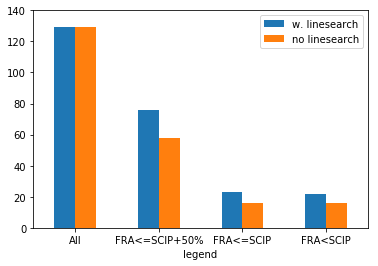

In [13]:
ax = df.plot.bar(x='legend', rot=0, width=0.5, ylim=(0,140))

### Diving Procedure for granular instances

In [21]:
d_result = pd.read_pickle('impact_diving_merged.pickle')
d_result.set_index('name', inplace=True)
print('There are ' + str(sum(~d_result['obj_diving_ls'].isnull())) + ' Instances, where diving+linesearch was performed')
# If no lineasearch performed, fill column with normal diving objective
d_result.obj_diving_ls.fillna(d_result.obj_diving, inplace=True) 
d_result.head()

There are 69 Instances, where diving+linesearch was performed


,depth,eq_constrs,pruned_prob,ips_nonempty,feasible,accepted,obj_best,obj_SCIP,time_heur,time_solveips,time_pp,time_scip,obj_ls,diving_depth,diving_best_depth,obj_diving,obj_diving_ls
name,,,,,,,,,,,,,,,,,
set3-09,0,False,False,True,True,True,9.266320e+05,1.759785e+06,87.021509,0.408947,1.875507,89.601070,9.266320e+05,176,23,1.134500e+06,1.134500e+06
set3-20,0,False,False,True,True,True,9.413491e+05,1.712935e+06,100.009418,0.547271,2.088797,102.623578,1.070825e+06,176,156,9.413491e+05,9.413491e+05
set3-10,0,False,False,True,True,True,1.017573e+06,1.756477e+06,86.077774,0.892102,1.998945,88.827707,1.029570e+06,176,33,1.017573e+06,1.017573e+06
neos-1367061,0,False,False,True,True,True,3.062046e+07,3.260046e+07,3105.261464,76.305429,7.092716,3124.127209,3.062046e+07,644,305,3.108076e+07,3.062046e+07
bg512142,0,False,False,True,True,True,2.681040e+05,6.290719e+06,13.366408,0.124084,1.095443,16.009597,2.907670e+05,230,219,2.681040e+05,2.681040e+05


### Add and compare diving results

Compare to SCIP result

In [15]:
# execute only once!
res_all = pd.merge(result,d_result.loc[:,['obj_diving','time_heur','diving_depth','diving_best_depth','obj_diving_ls']], how='inner', left_index=True, right_index=True)

In [36]:
res_all.head()

,depth,eq_constrs,ips_nonempty,feasible,accepted,obj_FRA,obj_SCIP,time_heur_x,time_solveips,time_pp,time_scip,impr_PP,no_pp,obj_diving,time_heur_y,diving_depth,diving_best_depth,obj_diving_ls
name,,,,,,,,,,,,,,,,,,
30_70_45_05_100,0,False,True,True,True,13582,5899,184.080329,14.29,168.544,223.736239,1146,14728,14574.000000,3793.023444,365,165,14574.000000
30_70_45_095_100,0,False,True,True,True,13606,6808,205.924535,13.1471,191.346,250.797632,1561,15167,10166.000000,9640.643555,10637,10535,10166.000000
30_70_45_095_98,0,False,True,True,True,12642,6791,212.485605,84.38,126.652,254.645360,2265,14907,14877.000000,3772.666796,335,335,14877.000000
50v-10,0,False,True,True,True,78474.8,6822.26,2.107072,0.430854,1.36866,9.408021,70039.4,148514,90334.399862,550.503152,1647,1224,90334.399862
a1c1s1,0,False,True,True,True,21995.3,19829.3,2.806553,0.778314,1.71098,9.279368,868.007,22863.3,21094.649000,42.929053,191,170,21094.649000


In [16]:
df['diving'] = compare_columns(res_all, c1='obj_diving', c2='obj_SCIP')
df['diving_ls'] = compare_columns(res_all, c1='obj_diving_ls', c2='obj_SCIP')
df

,legend,w. linesearch,no linesearch,diving,diving_ls
0,All,129.0,129.0,125.0,125.0
1,FRA<=SCIP+50%,76.0,58.0,86.0,94.0
2,FRA<=SCIP,23.0,16.0,27.0,32.0
3,FRA<SCIP,22.0,16.0,27.0,31.0


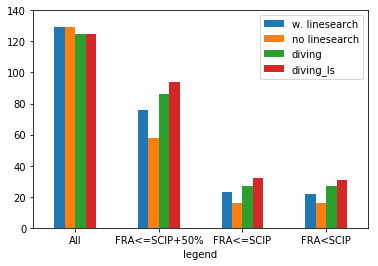

In [17]:
ax = df.plot.bar(x='legend', rot=0, width=0.5, ylim=(0,140))

Compare to FRA-Result

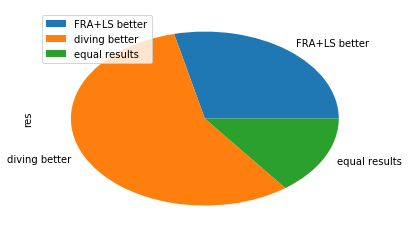

In [48]:
a = [sum(res_all['obj_FRA']<res_all['obj_diving_ls']),sum(res_all['obj_diving_ls']<res_all['obj_FRA']), sum(res_all['obj_diving_ls']==res_all['obj_FRA'])]
df2 = pd.DataFrame({'res':a}, index=['FRA+LS better','diving better', 'equal results'])
df2.plot.pie(y='res')

In [54]:
time = res_all['time_heur_y']/res_all['time_heur_x']
print('In median, the diving takes factor ' + str('{:4.1f}'.format(time.median())) + ' more time than FRA+LS')

In median, the diving takes factor 28.6 more time than FRA+LS


### Is diving+linesearch worth it?

In [35]:
print('In '+str(sum(res_all['obj_diving_ls']<res_all['obj_diving']))+ ' of the above counted 69 cases (' 
      + str('{:4.2f}'.format(sum(res_all['obj_diving_ls']<res_all['obj_diving'])/69 *100)) + '%), line-search improved the results')


In 26 of the above counted 69 cases (37.68%), line-search improved the results


## For which instances does it work?

In [92]:
# Overview
res_all[res_all['obj_diving_ls']<res_all['obj_SCIP']].drop(['depth','eq_constrs','feasible','accepted','ips_nonempty', 'time_heur_x', 'time_heur_y'], axis=1)

,obj_FRA,obj_SCIP,time_solveips,time_pp,time_scip,impr_PP,no_pp,obj_diving,diving_depth,diving_best_depth,obj_diving_ls
name,,,,,,,,,,,
b2c1s1,73548.3,72213.3,2.22301,3.33183,40.963538,1221,74769.3,6.804529e+04,280,170,6.804529e+04
bg512142,290767,6.29072e+06,0.121608,0.502592,3.344344,130,290897,2.681040e+05,230,219,2.681040e+05
dg012142,2.54268e+07,3.3358e+07,0.557419,2.28754,7.674775,121336,2.55481e+07,1.021287e+07,600,585,1.021287e+07
gen-ip054,7282.72,7235.3,0.000972748,0.00571823,0.027186,3645.47,10928.2,7.562778e+03,30,25,6.961828e+03
germany50-UUM,76512,73865,0.627476,3.55015,8.720981,2561,79073,6.709800e+04,88,79,6.709800e+04
gr4x6,202.35,219.35,0.00110364,0.00457668,0.022413,130,332.35,2.730000e+02,24,22,2.023500e+02
gsvm2rl11,42635.3,83555.9,0.795018,3.8745,11.907572,0,42635.3,3.953888e+04,500,410,3.953888e+04
gsvm2rl12,34.353,50,1.78263,3.70492,15.442372,0,34.353,3.764883e+01,500,280,3.764883e+01
gsvm2rl9,16382.8,31802.4,0.228253,0.581295,19.583684,0,16382.8,1.562326e+04,200,80,1.562326e+04


Let's have a look, for which kind of instances this happens

In [93]:
pprop = pd.read_csv('problem_properties.csv', index_col='Instance  Ins.')
pprop.head()

,Status Sta.,Variables Var.,Binaries Bin.,Integers Int.,Continuous Con.,Constraints Con.,Nonz. Non.,Submitter Sub.,Group Gro.,Objective Obj.,Tags Tag.
Instance Ins.,,,,,,,,,,,
10teams,easy,2025.0,1800.0,0.0,225,230,12150.0,MIPLIB submission pool,–,924,binary set_partitioning set_packing invariant_...
22433,easy,429.0,231.0,0.0,198,198,3408.0,MIPLIB submission pool,–,21477,mixed_binary general_linear
23588,easy,368.0,231.0,0.0,137,137,3701.0,MIPLIB submission pool,–,8090,mixed_binary general_linear
2club200v15p5scn,hard,200.0,200.0,0.0,0,17013,104811.0,Balabhaskar Balasundaram,–,-70,binary variable_bound invariant_knapsack
30_70_45_05_100,easy,10772.0,10771.0,0.0,1,12050,45889.0,J. Walser,30_70,9,binary decomposition benchmark_suitable preced...


In [94]:
best_instances = list(res_all[res_all['feasible'] & (res_all['obj_diving_ls']<=res_all['obj_SCIP'])].index)
problem_tags = list(pprop.loc[best_instances,'Tags  Tag.'])

import nltk, string
from nltk.tokenize import word_tokenize

tags = []
for tag in problem_tags:
    words = nltk.word_tokenize(tag)
    tags.append([w for w in words if w.lower() not in string.punctuation])

all_tags = []
for tag in tags:
    for t in tag:
        all_tags.append(t)
occuring_tags = list(set(all_tags))
share = []
for t in occuring_tags:
    share.append(sum([t in tags[i] for i in range(len(tags))]))
    
tag_df = pd.DataFrame({'tag':occuring_tags,'share':share})
tag_df['share'] = tag_df['share']/len(problem_tags)*100
tag_df

,tag,share
0,aggregations,25.000
1,mixed_binary,75.000
2,binary,18.750
3,variable_bound,75.000
4,precedence,46.875
5,benchmark_suitable,37.500
6,general_linear,21.875
7,integer_knapsack,3.125
8,decomposition,25.000
9,set_packing,6.250
